In [114]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
#import mplleaflet as mpll
import pylab as plt
import json
import pycrs

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask


# Flood analysis for the Employment Survey points
How does connectivity between a sample of firms in Kampala change with flooding?

In [115]:
gostNetsFolder = os.path.dirname(os.getcwd())
sys.path.insert(0, gostNetsFolder)

import GOSTnet as gn

In [116]:
# Data 
path = 'data'
tif = '50yrflood_Kampala.tif'
tif_path = os.path.join(path, tif)

#ED_points = 'jobdensity_kampala_points.shp'

#### 1. Import Kampala bounds and flood raster

In [117]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,32.668022,0.408476,0.21705,32.509629,"POLYGON ((32.5096294 0.3100581, 32.5097488 0.3...","Kampala, Central Region, Uganda"


In [118]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [119]:
raster = rasterio.open(tif_path)

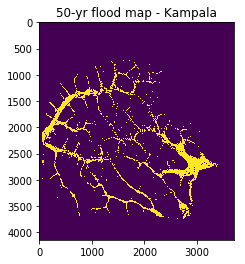

In [120]:
raster_arr = raster.read(1)
plt.imshow(raster_arr)
plt.title('50-yr flood map - Kampala');

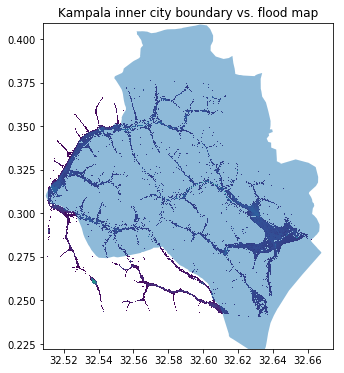

In [121]:
ax = boundary_GDF.plot(figsize=[6,6],alpha = 0.5)
show(raster, ax = ax)
plt.title('Kampala inner city boundary vs. flood map');

#### 2. Import employment survey points

In [122]:
boundary_JSON = getFeatures(boundary_GDF)         # boundary as json (for raster mask)
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [123]:
points_ES = gpd.read_file(os.path.join(path,'Points_ES.shp'))

In [124]:
points_ES.head(1)

,lat,lon,survey,WBCode,type,ID,geometry
0,0.314567,32.580786,Uganda2013,UGA,Enterprise Survey,890,POINT (32.5807859 0.3145672)


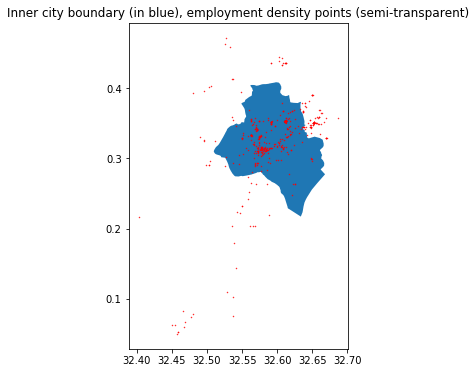

In [125]:
ax = boundary_GDF.plot(figsize=[6,6])
points_ES.plot(ax=ax, color='r', markersize = 0.2)
plt.title("Inner city boundary (in blue), employment density points (semi-transparent)");

#### 3. Clip raster to boundary

In [126]:
out_img, out_transform = mask(dataset=raster, shapes=boundary_JSON, crop=True)

# Update the metadata

out_meta = raster.meta.copy()
out_meta
epsg_code = int(raster.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                             )

In [127]:
out_tif = path + '/' + 'clipped_raster.tif'

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

#### 4. Clip ES points to boundary

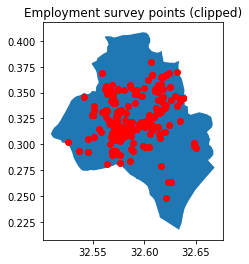

In [128]:
ES_clipped = gpd.sjoin(points_ES,boundary_GDF,how='inner')
ax = boundary_GDF.plot()
ES_clipped.plot(color='r',ax=ax)

plt.title('Employment survey points (clipped)');

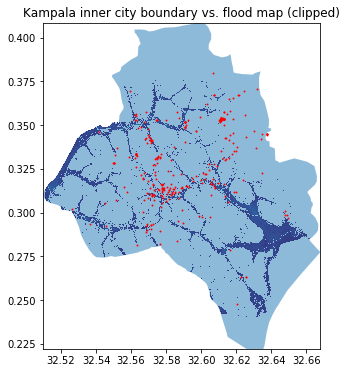

In [129]:
clipped_raster = rasterio.open(out_tif)
ax = boundary_GDF.plot(figsize=[6,6],alpha = 0.5)
ES_clipped.plot(markersize=0.8,color='r',ax=ax)
show(clipped_raster, ax = ax)
plt.title('Kampala inner city boundary vs. flood map (clipped)');

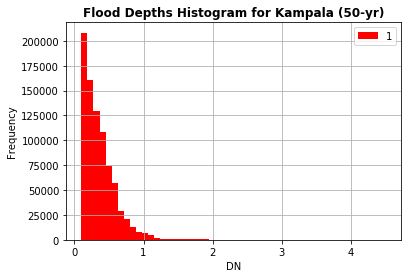

In [130]:
show_hist(clipped_raster,bins = 50, title = 'Flood Depths Histogram for Kampala (50-yr)')

#### 5. Get road network

In [131]:
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

## ANALYSIS
#### 6. Road network to time

In [132]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [133]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

In [134]:
gn.example_edge(G, 1)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f6f2cfa47f0>, 'time': 7.693560000000001, 'mode': 'drive'})


#### 7. Snap employment density points to graph

In [135]:
point_df_with_nearest_node_field = gn.pandana_snap(G, ES_clipped)
point_df_with_nearest_node_field.shape

/nfshome/nj935/Kampala/GOSTnet.py:1568: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/nfshome/nj935/Kampala/GOSTnet.py:1570: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


(307, 16)

#### 8. Map flooding onto graph

In [136]:
list_of_nearest_nodes = list(point_df_with_nearest_node_field.NN)
#unique_list_of_nearest_nodes = list(set(list_of_nearest_nodes))

In [137]:
len(list_of_nearest_nodes)
#len(unique_list_of_nearest_nodes)

307

In [138]:
importlib.reload(gn)
G = gn.sample_raster(G, out_tif, property_name = 'flood_depth')

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [139]:
G_node_gdf = gn.node_gdf_from_graph(G)

print("Flooding is positive in {:.1f}% of nodes.".format(
    (G_node_gdf[G_node_gdf.flood_depth > 0].shape[0] / G_node_gdf.shape[0])*100))

print("Flooding exceeds 15 centimeters for {:.1f}% of nodes and exceeds 40 centimeters for {:.1f}% of nodes.".format(
    ((G_node_gdf[G_node_gdf.flood_depth > 0.15].shape[0] / G_node_gdf.shape[0]*100)),
    (G_node_gdf[G_node_gdf.flood_depth > 0.4].shape[0] / G_node_gdf.shape[0])*100))

Flooding is positive in 4.1% of nodes.
Flooding exceeds 15 centimeters for 3.0% of nodes and exceeds 40 centimeters for 0.6% of nodes.


#### 9. Calculate baseline OD matrix

In [140]:
fail_value = 999999999999999
#baseline_OD = gn.calculate_OD(G, list_of_nearest_nodes, list_of_nearest_nodes, fail_value)


In [141]:
baseline_OD_distance = gn.calculate_OD(G, list_of_nearest_nodes, list_of_nearest_nodes, fail_value, weight='length')

In [39]:
OD_df = pd.DataFrame(baseline_OD)
OD_df.to_csv('data/baseline_OD.csv')
OD_df.head()

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,0.00000,430.050390,243.99684,714.984570,310.837161,345.870240,141.374400,811.118790,153.771330,252.536499,...,136.538160,294.868680,637.260900,587.380860,493.322730,360.692940,760.471830,227.15457,417.80031,136.538160
1,445.92663,0.000000,535.32222,284.934180,217.419120,618.344100,522.783420,382.703010,543.691230,593.660919,...,517.947180,635.993100,207.210510,859.854720,765.796590,145.121640,403.707150,561.34944,755.19342,517.947180
2,247.83300,555.561561,0.00000,840.495741,436.348333,155.161359,287.751591,592.465449,223.882551,410.691111,...,282.915351,498.206643,723.216249,396.671979,302.613849,455.284629,541.818489,50.59914,244.44312,282.915351
3,730.86081,284.934180,820.25640,0.000000,502.353300,903.278280,807.717600,581.570460,828.625410,878.595099,...,802.881360,920.927280,413.197590,1144.788900,1050.730770,430.055820,594.608220,846.28362,1040.12760,802.881360
4,318.90261,225.005734,408.29820,509.939914,0.000000,491.320080,395.759400,607.708744,416.667210,466.636899,...,390.923160,508.969080,432.216244,732.830700,638.772570,155.648284,600.700324,434.32542,628.16940,390.923160


#### 10. Disrupt network, calculate flooded OD matrix

In [142]:
my_flood_depth = 0.15

In [143]:
importlib.reload(gn)
G_flood = G.copy()
G_flood = gn.disrupt_network(G_flood, 'flood_depth', my_flood_depth, fail_value)

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 
nodes disrupted: 412
edges disrupted: 1195


In [42]:
flood_OD = gn.calculate_OD(G_flood, list_of_nearest_nodes, list_of_nearest_nodes, fail_value)

In [144]:
flood_OD_distance = gn.calculate_OD(G_flood, list_of_nearest_nodes, list_of_nearest_nodes, fail_value, weight = 'length')

In [43]:
flood_OD_df = pd.DataFrame(flood_OD)

#### 11. Plot how the travel times differ

In [44]:
PRE_travel_times = baseline_OD[baseline_OD < fail_value]
PRE_travel_times = PRE_travel_times /60

POST_travel_times = flood_OD[flood_OD < fail_value]
POST_travel_times = POST_travel_times /60

In [113]:
flood_OD.mean()

267525384885459.62

In [145]:
PRE_distances = baseline_OD_distance[baseline_OD_distance < fail_value]

POST_distances = flood_OD_distance[flood_OD_distance < fail_value]

In [45]:
print("Travel times between firms in the enterprise survey (flood depth threshold: 10 cm)")
print()
print("Pre-flood: mean travel time {:.2f} minutes".format(PRE_travel_times.mean()))
print("Post-flood: mean travel time {:.2f} minutes".format(POST_travel_times.mean()))
print("Mean journey time increases by {:.1f}%".format((POST_travel_times.mean()-PRE_travel_times.mean()
                                                     )/PRE_travel_times.mean()*100))

Travel times between firms in the enterprise survey (flood depth threshold: 10 cm)

Pre-flood: mean travel time 10.39 minutes
Post-flood: mean travel time 12.45 minutes
Mean journey time increases by 19.8%


In [48]:
POST_travel_times.max()

43.536995499999996

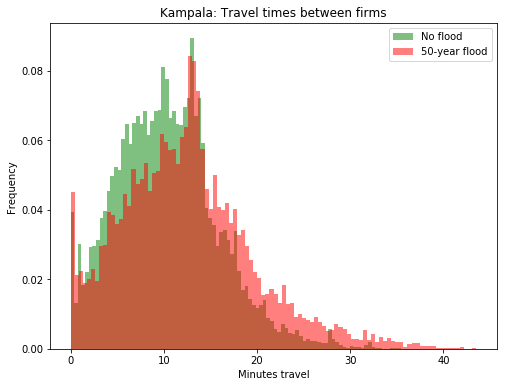

In [149]:
# Histogram of post-flood travel times between firms

fig,ax = plt.subplots(figsize=[8,6])
ax.hist(PRE_travel_times,color='g',alpha=0.5,density=True,bins=100)
ax.hist(POST_travel_times,color='r',alpha=0.5,density=True,bins=100)
plt.title('Kampala: Travel times between firms')
plt.ylabel('Frequency')
plt.legend(['No flood','50-year flood'])
plt.xlabel('Minutes travel');

In [146]:
import seaborn as sns

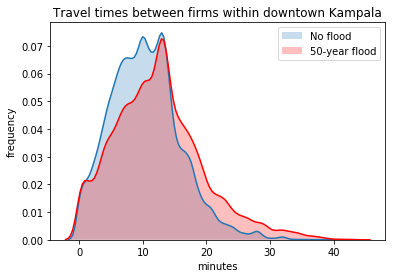

In [147]:
ax = sns.kdeplot(PRE_travel_times,shade=True)
sns.kdeplot(POST_travel_times, ax=ax, color='r',shade=True)
ax.set_title('Travel times between firms within downtown Kampala')
plt.legend(['No flood','50-year flood'])
ax.set(xlabel="minutes", ylabel='frequency');

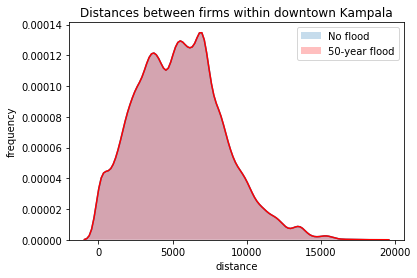

In [148]:
ax = sns.kdeplot(PRE_distances,shade=True)
sns.kdeplot(POST_distances, ax=ax, color='r',shade=True)
ax.set_title('Distances between firms within downtown Kampala')
plt.legend(['No flood','50-year flood'])
ax.set(xlabel="distance", ylabel='frequency');